In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
import pandas as pd
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import cv2
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/BMW/BMW-model.v1i.multiclass.zip'

In [ ]:
import zipfile

# zip 파일을 열고 압축을 풀기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images')

In [ ]:
# 각 라벨의 개수 확인
df = pd.read_csv('/content/images/train/_classes.csv')
image_dir_train = '/content/images/train/'
image_dir_valid = '/content/images/valid/'
image_dir_test = '/content/images/test/'
counts = df.iloc[:, 1:].sum(axis=0)
print(counts)

BMW_1-Series_2004-2013              420
BMW_1-Series_2011-2019              375
BMW_2-Series-Tourer_2014-present    395
BMW_3-Series_E46                    402
BMW_3-Series_E90-E91                403
BMW_3-Series_E92-E93                393
BMW_3-Series_F30-F34                415
BMW_3-Series_G20-G21                415
BMW_4-Series_2014-2020              410
BMW_5-Series-GT_F07                 396
BMW_5-Series_E39                    372
BMW_5-Series_E60-E61                404
BMW_5-Series_F10-F11                392
BMW_5-Series_G30-G31                368
BMW_7-Series_2008-2015              390
BMW_7-Series_2015-2022              460
BMW_X3_2017-present                 402
BMW_X5_2007-2013                    418
BMW_X5_2013-2018                    433
BMW_X5_2018-present                 391
BMW_X6_2007-2014                    412
BMW_X6_2014-2019                    409
dtype: int64


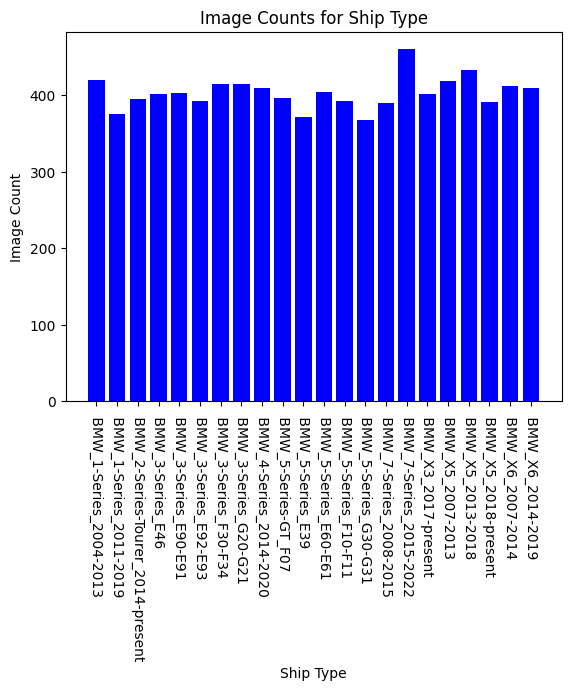

In [ ]:
# 막대 그래프 생성
plt.bar(df.columns[1:], counts, color='blue')
plt.xticks(rotation=-90)
plt.xlabel('Ship Type')
plt.ylabel('Image Count')
plt.title('Image Counts for Ship Type')
plt.show()

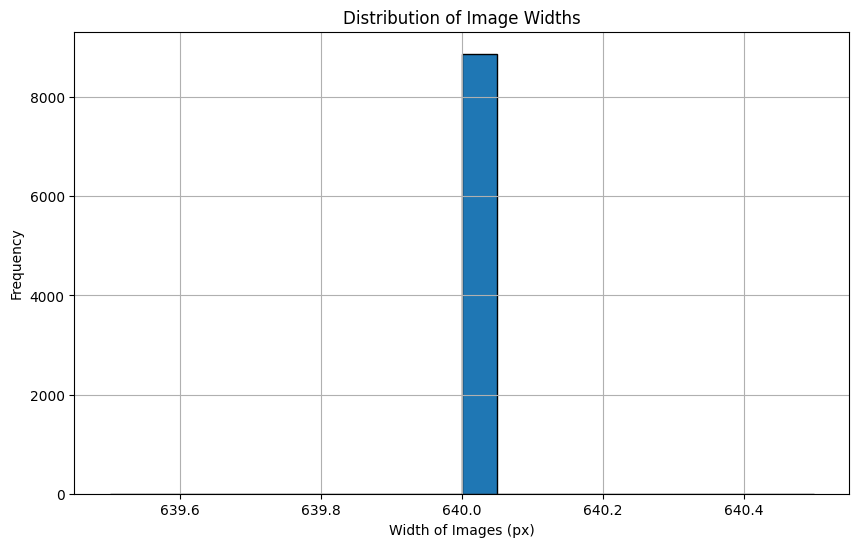

In [ ]:
image_widths = []
image_files = [f for f in os.listdir(image_dir_train) if f.endswith('.jpg')]

# 각 이미지의 가로 길이를 추출
for image_file in image_files:
    img_path = os.path.join(image_dir_train, image_file)
    img = Image.open(img_path)

    # 이미지의 가로 길이 가져오기
    width, height = img.size
    image_widths.append(width)

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.hist(image_widths, bins=20, edgecolor='black')  # 막대그래프, bins로 구간 수 설정
plt.title('Distribution of Image Widths')  # 그래프 제목
plt.xlabel('Width of Images (px)')  # x축 레이블
plt.ylabel('Frequency')  # y축 레이블
plt.grid(True)
plt.show()

# 모든 이미지가 640 * 640 정사각형으로 같은 크기

In [ ]:
# 데이터셋
train_df = df
valid_df = pd.read_csv(f'/content/images/valid/_classes.csv')
test_df = pd.read_csv(f'/content/images/test/_classes.csv')

In [ ]:
print(train_df.columns[1:])

Index([' BMW_1-Series_2004-2013', ' BMW_1-Series_2011-2019',
       ' BMW_2-Series-Tourer_2014-present', ' BMW_3-Series_E46',
       ' BMW_3-Series_E90-E91', ' BMW_3-Series_E92-E93',
       ' BMW_3-Series_F30-F34', ' BMW_3-Series_G20-G21',
       ' BMW_4-Series_2014-2020', ' BMW_5-Series-GT_F07', ' BMW_5-Series_E39',
       ' BMW_5-Series_E60-E61', ' BMW_5-Series_F10-F11',
       ' BMW_5-Series_G30-G31', ' BMW_7-Series_2008-2015',
       ' BMW_7-Series_2015-2022', ' BMW_X3_2017-present', ' BMW_X5_2007-2013',
       ' BMW_X5_2013-2018', ' BMW_X5_2018-present', ' BMW_X6_2007-2014',
       ' BMW_X6_2014-2019'],
      dtype='object')


In [ ]:
# 사용자 정의 데이터셋 클래스 생성
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        # 데이터셋 초기화
        self.dataframe = dataframe
        self.transform = transform
        self.image_dir = image_dir

        # CSV 파일에서 이미지 파일 이름과 레이블을 가져옴
        self.image_names = self.dataframe['filename'].tolist()

        # 레이블 컬럼들
        label_columns = [' BMW_1-Series_2004-2013', ' BMW_1-Series_2011-2019',
       ' BMW_2-Series-Tourer_2014-present', ' BMW_3-Series_E46',
       ' BMW_3-Series_E90-E91', ' BMW_3-Series_E92-E93',
       ' BMW_3-Series_F30-F34', ' BMW_3-Series_G20-G21',
       ' BMW_4-Series_2014-2020', ' BMW_5-Series-GT_F07', ' BMW_5-Series_E39',
       ' BMW_5-Series_E60-E61', ' BMW_5-Series_F10-F11',
       ' BMW_5-Series_G30-G31', ' BMW_7-Series_2008-2015',
       ' BMW_7-Series_2015-2022', ' BMW_X3_2017-present', ' BMW_X5_2007-2013',
       ' BMW_X5_2013-2018', ' BMW_X5_2018-present', ' BMW_X6_2007-2014',
       ' BMW_X6_2014-2019']

        # 각 항목의 레이블을 하나의 값으로 통합 (단일 레이블 추출)
        self.labels = self.dataframe[label_columns].apply(lambda row: row.idxmax(), axis=1).tolist()  # 1이 있는 인덱스를 레이블로 사용

        # 레이블 인코딩 (문자열을 숫자로 변환)
        self.label_encoder = preprocessing.LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)  # 숫자 레이블로 변환

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        # 이미지 파일 경로가 잘못되었을 경우 예외 처리
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image file not found: {img_name}")
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # 레이블 정보를 정수형으로 가져옴
        label = self.labels[idx]

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 레이블을 반환
        return img, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 224x224 크기로 리사이즈
    transforms.ToTensor(),  # 이미지를 텐서로 변환 (0~1 범위로)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 기준 정규화
])

In [ ]:
batch_size = 448

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, image_dir=image_dir_train, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, image_dir=image_dir_valid, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, image_dir=image_dir_test, transform=transform)

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(pretrained=True)

# 모델의 마지막 완전 연결 계층(fc)을 사용자 정의 계층으로 대체
# 이 계층은 in_features에서 10개의 출력으로 매핑합니다 (10개 클래스 분류를 위함)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 22),
)

# 교차 엔트로피 손실 함수 초기화
criterion = nn.CrossEntropyLoss()
# 최적화 알고리즘으로 Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [ ]:
# 학습 파라미터 설정
num_epochs = 50  # 학습 반복 횟수
best_val_acc = 0.0  # 최상의 검증 정확도를 저장하는 변수
patience = 5  # 얼리 스탑핑을 위한 patience 설정 (개선되지 않은 횟수)
no_improve = 0  # 개선되지 않은 에포크 수를 카운트하는 변수

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    # 모델을 학습 모드로 전환
    model.train()
    running_loss = 0.0  # 에포크 동안의 총 손실을 저장하는 변수
    correct_train = 0  # 정확하게 예측한 학습 데이터의 개수를 저장하는 변수
    total_train = 0  # 총 학습 데이터 개수를 저장하는 변수

    # 학습 데이터를 반복하여 모델 업데이트
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        # 데이터를 장치로 이동 (GPU 또는 CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()
        # 모델에 입력을 전달하여 예측값 출력
        outputs = model(inputs)
        # 손실 함수 계산
        loss = criterion(outputs, labels)
        # 손실에 대한 역전파 수행 (기울기 계산)
        loss.backward()
        # 옵티마이저를 통해 모델 파라미터 업데이
        optimizer.step()
        # 현재 배치의 손실을 누적
        running_loss += loss.item()

        # 정확도 계산을 위한 예측값 처리
        _, predicted = torch.max(outputs.data, 1) # 최대값을 가지는 클래스 예측
        total_train += labels.size(0) # 총 학습 데이터 수 누적
        correct_train += (predicted == labels).sum().item() # 맞춘 예측의 개수 누적

    # 에포크별 학습 정확도와 손실 계산
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validate
    model.eval()  # 모델을 평가 모드로 전환 (드롭아웃, 배치 정규화 등 비활성화)
    running_val_loss = 0.0  # 검증 손실을 저장하는 변수
    correct_val = 0  # 정확하게 예측한 검증 데이터의 개수를 저장하는 변수
    total_val = 0  # 총 검증 데이터 개수를 저장하는 변수
    with torch.no_grad(): # 검증 시에는 기울기를 계산하지 않음 (메모리 및 계산량 절약)
        for inputs, labels in valid_loader:
            # 데이터를 장치로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            # 모델에 입력을 전달하여 예측값 출력
            outputs = model(inputs)
            # 손실 함수 계산
            loss = criterion(outputs, labels)
            # 현재 배치의 손실을 누적
            running_val_loss += loss.item()

            # 정확도 계산을 위한 예측값 처리
            _, predicted = torch.max(outputs.data, 1)  # 최대값을 가지는 클래스 예측
            total_val += labels.size(0)  # 총 검증 데이터 수 누적
            correct_val += (predicted == labels).sum().item()  # 맞춘 예측의 개수 누적

    # 에포크별 검증 정확도와 손실 계산
    val_acc = correct_val / total_val  # 검증 정확도 계산
    val_loss = running_val_loss / len(valid_loader)  # 검증 손실 평균 계산

    # 손실 기록
    train_losses.append(train_loss)
    valid_losses.append(val_loss)

    # 학습 및 검증 결과 출력
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

     # 최상의 검증 정확도를 기록하고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_before.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break

print('Finished Training')

Epoch 1/50: 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]


Train Loss: 3.2036, Train Accuracy: 0.0606, Validation Loss: 3.2587, Validation Accuracy: 0.0507


Epoch 2/50: 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]


Train Loss: 3.0039, Train Accuracy: 0.0879, Validation Loss: 3.0695, Validation Accuracy: 0.0727


Epoch 3/50: 100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


Train Loss: 2.8312, Train Accuracy: 0.1401, Validation Loss: 2.9035, Validation Accuracy: 0.1188


Epoch 4/50: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


Train Loss: 2.6657, Train Accuracy: 0.2220, Validation Loss: 2.7622, Validation Accuracy: 0.1834


Epoch 5/50: 100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


Train Loss: 2.5073, Train Accuracy: 0.3037, Validation Loss: 2.6405, Validation Accuracy: 0.2353


Epoch 6/50: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]


Train Loss: 2.3495, Train Accuracy: 0.3897, Validation Loss: 2.5212, Validation Accuracy: 0.2710


Epoch 7/50: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Train Loss: 2.1985, Train Accuracy: 0.4700, Validation Loss: 2.4085, Validation Accuracy: 0.3068


Epoch 8/50: 100%|██████████| 20/20 [01:15<00:00,  3.79s/it]


Train Loss: 2.0531, Train Accuracy: 0.5377, Validation Loss: 2.3038, Validation Accuracy: 0.3368


Epoch 9/50: 100%|██████████| 20/20 [01:11<00:00,  3.55s/it]


Train Loss: 1.9175, Train Accuracy: 0.5935, Validation Loss: 2.2083, Validation Accuracy: 0.3818


Epoch 10/50: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Train Loss: 1.7901, Train Accuracy: 0.6442, Validation Loss: 2.1199, Validation Accuracy: 0.4083


Epoch 11/50: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Train Loss: 1.6705, Train Accuracy: 0.6915, Validation Loss: 2.0402, Validation Accuracy: 0.4291


Epoch 12/50: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]


Train Loss: 1.5558, Train Accuracy: 0.7351, Validation Loss: 1.9645, Validation Accuracy: 0.4498


Epoch 13/50: 100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


Train Loss: 1.4496, Train Accuracy: 0.7726, Validation Loss: 1.8960, Validation Accuracy: 0.4694


Epoch 14/50: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Train Loss: 1.3481, Train Accuracy: 0.8045, Validation Loss: 1.8329, Validation Accuracy: 0.4810


Epoch 15/50: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Train Loss: 1.2519, Train Accuracy: 0.8354, Validation Loss: 1.7762, Validation Accuracy: 0.4971


Epoch 16/50: 100%|██████████| 20/20 [01:15<00:00,  3.80s/it]


Train Loss: 1.1630, Train Accuracy: 0.8569, Validation Loss: 1.7168, Validation Accuracy: 0.5110


Epoch 17/50: 100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


Train Loss: 1.0751, Train Accuracy: 0.8785, Validation Loss: 1.6683, Validation Accuracy: 0.5329


Epoch 18/50: 100%|██████████| 20/20 [01:11<00:00,  3.56s/it]


Train Loss: 0.9953, Train Accuracy: 0.8981, Validation Loss: 1.6232, Validation Accuracy: 0.5525


Epoch 19/50: 100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


Train Loss: 0.9175, Train Accuracy: 0.9141, Validation Loss: 1.5786, Validation Accuracy: 0.5686


Epoch 20/50: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Train Loss: 0.8458, Train Accuracy: 0.9275, Validation Loss: 1.5389, Validation Accuracy: 0.5779


Epoch 21/50: 100%|██████████| 20/20 [01:11<00:00,  3.56s/it]


Train Loss: 0.7787, Train Accuracy: 0.9405, Validation Loss: 1.5051, Validation Accuracy: 0.5894


Epoch 22/50: 100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


Train Loss: 0.7152, Train Accuracy: 0.9526, Validation Loss: 1.4672, Validation Accuracy: 0.5986


Epoch 23/50: 100%|██████████| 20/20 [01:10<00:00,  3.52s/it]


Train Loss: 0.6566, Train Accuracy: 0.9618, Validation Loss: 1.4401, Validation Accuracy: 0.6009


Epoch 24/50: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Train Loss: 0.6004, Train Accuracy: 0.9689, Validation Loss: 1.4054, Validation Accuracy: 0.6113


Epoch 25/50: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Train Loss: 0.5504, Train Accuracy: 0.9748, Validation Loss: 1.3832, Validation Accuracy: 0.6125


Epoch 26/50: 100%|██████████| 20/20 [01:10<00:00,  3.51s/it]


Train Loss: 0.5035, Train Accuracy: 0.9812, Validation Loss: 1.3558, Validation Accuracy: 0.6275


Epoch 27/50: 100%|██████████| 20/20 [01:10<00:00,  3.52s/it]


Train Loss: 0.4603, Train Accuracy: 0.9842, Validation Loss: 1.3318, Validation Accuracy: 0.6275


Epoch 28/50: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Train Loss: 0.4211, Train Accuracy: 0.9877, Validation Loss: 1.3086, Validation Accuracy: 0.6367


Epoch 29/50: 100%|██████████| 20/20 [01:11<00:00,  3.57s/it]


Train Loss: 0.3845, Train Accuracy: 0.9915, Validation Loss: 1.2871, Validation Accuracy: 0.6401


Epoch 30/50: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


Train Loss: 0.3511, Train Accuracy: 0.9932, Validation Loss: 1.2708, Validation Accuracy: 0.6401


Epoch 31/50: 100%|██████████| 20/20 [01:06<00:00,  3.34s/it]


Train Loss: 0.3216, Train Accuracy: 0.9949, Validation Loss: 1.2529, Validation Accuracy: 0.6505


Epoch 32/50: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


Train Loss: 0.2939, Train Accuracy: 0.9971, Validation Loss: 1.2343, Validation Accuracy: 0.6551


Epoch 33/50: 100%|██████████| 20/20 [01:10<00:00,  3.50s/it]


Train Loss: 0.2679, Train Accuracy: 0.9974, Validation Loss: 1.2208, Validation Accuracy: 0.6563


Epoch 34/50: 100%|██████████| 20/20 [01:06<00:00,  3.33s/it]


Train Loss: 0.2464, Train Accuracy: 0.9982, Validation Loss: 1.2031, Validation Accuracy: 0.6586


Epoch 35/50: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]


Train Loss: 0.2252, Train Accuracy: 0.9990, Validation Loss: 1.1940, Validation Accuracy: 0.6667


Epoch 36/50: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Train Loss: 0.2076, Train Accuracy: 0.9991, Validation Loss: 1.1799, Validation Accuracy: 0.6655


Epoch 37/50: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Train Loss: 0.1906, Train Accuracy: 0.9997, Validation Loss: 1.1681, Validation Accuracy: 0.6713


Epoch 38/50: 100%|██████████| 20/20 [01:06<00:00,  3.35s/it]


Train Loss: 0.1758, Train Accuracy: 0.9998, Validation Loss: 1.1580, Validation Accuracy: 0.6736


Epoch 39/50: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


Train Loss: 0.1621, Train Accuracy: 1.0000, Validation Loss: 1.1484, Validation Accuracy: 0.6747


Epoch 40/50: 100%|██████████| 20/20 [01:10<00:00,  3.51s/it]


Train Loss: 0.1504, Train Accuracy: 1.0000, Validation Loss: 1.1382, Validation Accuracy: 0.6736


Epoch 41/50: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]


Train Loss: 0.1387, Train Accuracy: 1.0000, Validation Loss: 1.1298, Validation Accuracy: 0.6747


Epoch 42/50: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


Train Loss: 0.1290, Train Accuracy: 1.0000, Validation Loss: 1.1206, Validation Accuracy: 0.6828


Epoch 43/50: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]


Train Loss: 0.1204, Train Accuracy: 1.0000, Validation Loss: 1.1133, Validation Accuracy: 0.6817


Epoch 44/50: 100%|██████████| 20/20 [01:10<00:00,  3.53s/it]


Train Loss: 0.1121, Train Accuracy: 1.0000, Validation Loss: 1.1055, Validation Accuracy: 0.6851


Epoch 45/50: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Train Loss: 0.1039, Train Accuracy: 1.0000, Validation Loss: 1.0998, Validation Accuracy: 0.6851


Epoch 46/50: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]


Train Loss: 0.0969, Train Accuracy: 1.0000, Validation Loss: 1.0917, Validation Accuracy: 0.6840


Epoch 47/50: 100%|██████████| 20/20 [01:10<00:00,  3.50s/it]


Train Loss: 0.0903, Train Accuracy: 1.0000, Validation Loss: 1.0875, Validation Accuracy: 0.6840


Epoch 48/50: 100%|██████████| 20/20 [01:14<00:00,  3.70s/it]


Train Loss: 0.0847, Train Accuracy: 1.0000, Validation Loss: 1.0800, Validation Accuracy: 0.6828


Epoch 49/50: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


Train Loss: 0.0798, Train Accuracy: 1.0000, Validation Loss: 1.0765, Validation Accuracy: 0.6840
Early stopping
Finished Training


In [ ]:
model.load_state_dict(torch.load('best_model_before.pth'))

<ipython-input-15-2ef6e2ac1d8e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_before.pth'))


<All keys matched successfully>

In [ ]:
# 실제 클래스와 예측된 클래스 저장용 리스트
all_labels = []
all_preds = []

# 모델 예측 수행
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # 예측된 클래스

        all_labels.extend(labels.cpu().numpy())  # 실제 클래스
        all_preds.extend(preds.cpu().numpy())  # 예측된 클래스

# 혼동 행렬 계산
conf_matrix = confusion_matrix(all_labels, all_preds)

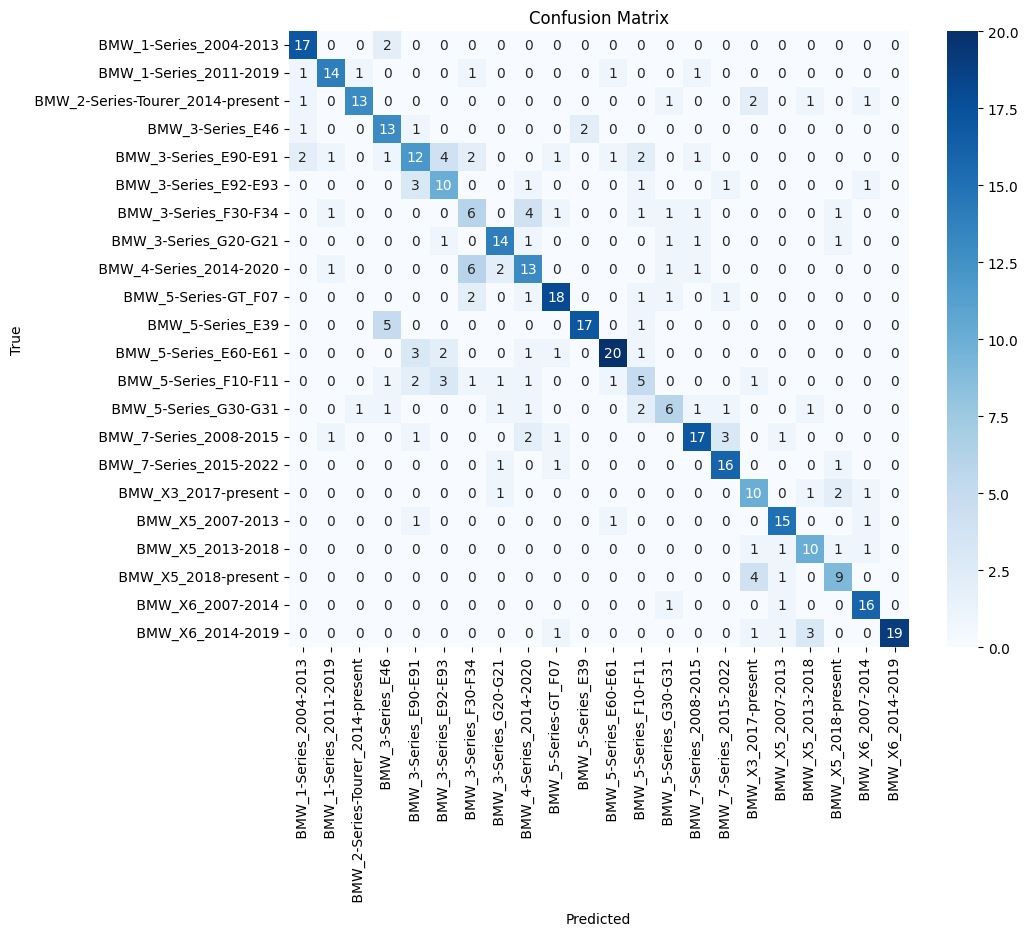

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.label_encoder.classes_, yticklabels=train_dataset.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

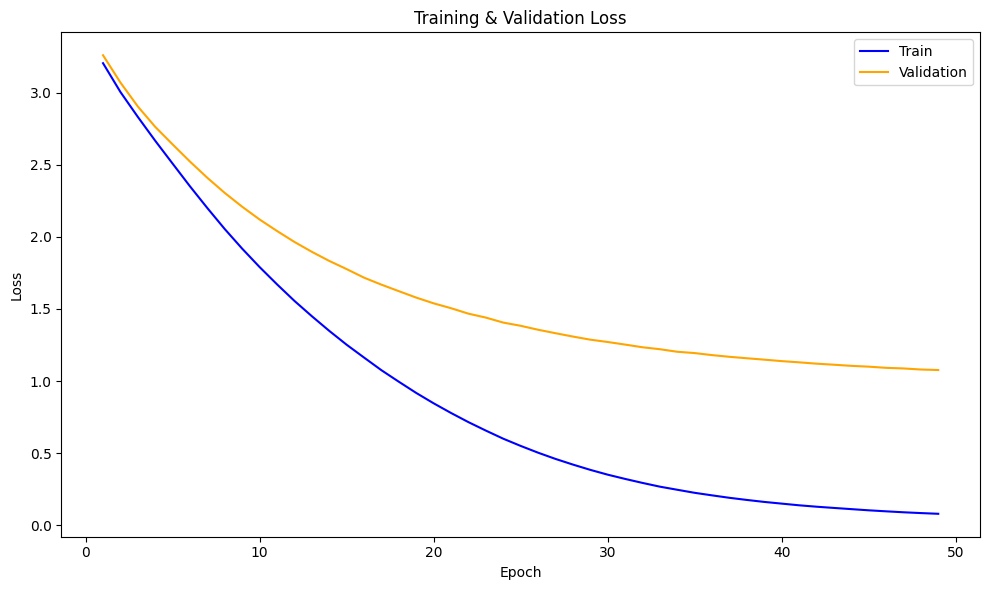

In [ ]:
actual_epochs = len(train_losses)
plt.figure(figsize=(10, 6))

# Train Loss 그래프, Validation Loss 그래프
plt.plot(range(1, actual_epochs + 1), train_losses, label='Train', color='blue')
plt.plot(range(1, actual_epochs + 1), valid_losses, label='Validation', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [ ]:
# Test
model.eval()

# 테스트 손실 및 정확도 계산을 위한 변수 초기화
running_test_loss = 0.0
correct_test = 0
total_test = 0

# 테스트 데이터에 대해 기울기 계산을 하지 않음 (메모리 및 계산량 절약)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델을 통해 예측값을 얻음
        outputs = model(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

        # 예측값 계산
        _, predicted = torch.max(outputs.data, 1)

        # 총 테스트 데이터 수와 맞춘 예측의 개수를 누적
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# 테스트 정확도와 손실 계산
test_accuracy = correct_test / total_test
test_loss = running_test_loss / len(test_loader)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 1.1312
Test Accuracy: 0.6713


In [27]:
import torch.nn.functional as F

def guess(image_path):

    # 이미지 로드 및 전처리
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # 배치 차원 추가 (1, C, H, W)

    # 장치로 이동
    img_tensor = img_tensor.to(device)

    # 모델에 이미지 입력하여 예측
    with torch.no_grad():
        outputs = model(img_tensor)

        # 소프트맥스를 사용하여 확률 분포로 변환
        probabilities = F.softmax(outputs, dim=1)  # 각 클래스에 대한 확률
        _, predicted = torch.max(outputs, 1)  # 예측된 클래스의 인덱스

    # 예측된 클래스
    predicted_class = predicted.item()

    # 예측된 클래스의 레이블을 출력 (인코딩된 레이블을 디코딩하여 클래스 이름으로 변환)
    predicted_label = train_dataset.label_encoder.inverse_transform([predicted_class])[0]

    # 상위 2개의 예측과 확률을 출력 (소프트맥스 확률)
    probs, classes = torch.topk(probabilities, 3)  # 상위 3개의 예측과 확률
    probs = probs.squeeze().cpu().numpy()  # 확률을 CPU로 이동시켜서 numpy 배열로 변환
    classes = classes.squeeze().cpu().numpy()  # 클래스 인덱스를 CPU로 이동시켜서 numpy 배열로 변환

    top_2_labels = train_dataset.label_encoder.inverse_transform(classes)  # 클래스 이름으로 변환

    print(f"Predicted ship type: {predicted_label}")
    print(f"Top 2 predictions:")
    for label, prob in zip(top_2_labels, probs):
        print(f"{label}: {prob * 100:.2f}%")

In [28]:
# 내 이미지를 맞출수 있는지 확인
image_path = f'/content/images/my_image/my_image_m3_e92.jpg'
guess(image_path)

Predicted ship type:  BMW_3-Series_E90-E91
Top 2 predictions:
 BMW_3-Series_E90-E91: 17.12%
 BMW_3-Series_E92-E93: 8.63%
 BMW_X6_2007-2014: 8.05%


In [29]:
# 내 이미지를 맞출수 있는지 확인
image_path = f'/content/images/my_image/my_image_520d_front.jpg'
guess(image_path)

Predicted ship type:  BMW_5-Series_F10-F11
Top 2 predictions:
 BMW_5-Series_F10-F11: 37.40%
 BMW_3-Series_E90-E91: 16.51%
 BMW_7-Series_2008-2015: 14.32%
